## 1. Setup

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from surrogate_model_functions import plot_3d_model, loo_error
from summit.strategies import TSEMO
from summit.models import GPyModel
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, DescriptorsVariable,ContinuousVariable
from summit.initial_design import LatinDesigner
# from summit.optimizers import EnumerationOptimizer
# from summit.objective import HV

import GPy
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Visualize values for all solvents
random_state = np.random.RandomState(1000)
all_experiments = [experiment(cas, random_state) for cas in solvent_ds_pcs.index.values]
all_experiments = np.array(all_experiments)
ax = plt.subplot(111)
ax.set_xlabel('Conversion'); ax.set_ylabel('DE')
ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='x')
max_idx = np.argmax(all_experiments, axis=0)
solvent_ds_pcs.iloc[max_idx, :]

NameError: name 'solvent_ds_pcs' is not defined

## 2. _In-Silico_ Optimization

In [ ]:
random_state = np.random.RandomState(1000)

In [ ]:
#Create up optimization domain
domain = Domain()
domain += DescriptorsVariable(name='solvent',
                             description='solvent for the borrowing hydrogen reaction',
                             ds=solvent_ds_pcs)
domain += ContinuousVariable(name='conversion',
                             description='relative conversion to triphenylphosphine oxide determined by LCMS',
                             bounds=[0, 100],
                             is_output=True)
domain += ContinuousVariable(name='de',
                             description='diastereomeric excess determined by ratio of LCMS peaks',
                             bounds=[0, 100],
                             is_output=True)
domain

In [ ]:
#Initial design
lhs = LatinDesigner(domain,random_state)
initial_design = lhs.generate_experiments(8)
initial_design

In [ ]:
#Initial experiments
initial_experiments = [experiment(cas, random_state) 
                       for cas in initial_design.to_frame()['cas_number']]
initial_experiments = pd.DataFrame(initial_experiments, columns=['conversion', 'de'])
initial_experiments = DataSet.from_df(initial_experiments)
design_df = initial_design.to_frame()
design_df = design_df.rename(index=int, columns={'cas_number': 'solvent'})
design_ds = DataSet.from_df(design_df)
initial_experiments = initial_experiments.merge(design_ds, left_index=True, right_index=True)
initial_experiments

In [ ]:
#Run the optimization
input_dim = domain.num_continuous_dimensions() +domain.num_discrete_variables()
kernels = [GPy.kern.Matern52(input_dim = input_dim, ARD=True)
           for _ in range(2)]
models = [GPyModel(kernel=kernels[i]) for i in range(2)]
# tsemo = TSEMO(domain, models, acquisition=HV(), optimizer=EnumerationOptimizer())
tsemo = TSEMO(domain, models)
design = tsemo.generate_experiments(initial_experiments, 8, 
                                    normalize=True, num_spectral_samples=500)
design

In [427]:
#Next set of experiments
lengthscales = np.zeros([num_batches, num_components, 2])
lengthscales[0, :, :] = np.array([model._model.kern.lengthscale.values for model in models]).T
experiments = initial_experiments.copy()
new_experiments = [experiment(cas, random_state)
                   for cas in design.index.values]
new_experiments = np.array(new_experiments)
new_experiments = DataSet({('conversion', 'DATA'): new_experiments[:, 0],
                           ('de', 'DATA'): new_experiments[:, 1],
                           ('solvent', 'DATA'): design.index.values})
new_experiments = new_experiments.set_index(np.arange(8, 16))
new_experiments.columns.names = ['NAME', 'TYPE']
previous_experiments = initial_experiments.append(new_experiments)
previous_experiments

,conversion,de,solvent
0,56.408818,82.084346,141-78-6
1,59.963037,81.731371,107-21-1
2,53.962345,65.937963,76-05-1
3,65.367399,85.857975,96-49-1
4,53.992682,81.057282,75-52-5
5,56.855803,87.753177,105-58-8
6,76.444236,82.069197,100-51-6
7,77.035052,83.543371,111-87-5
8,54.697520,69.050326,76-05-1
9,83.174170,84.238927,126-33-0


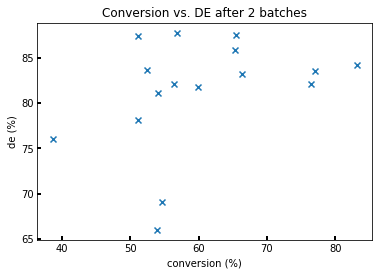

In [428]:
#Visualize the data
fig = plt.figure()
ax = plt.subplot(111)
data = previous_experiments.data_to_numpy()
ax.scatter(data[:, 0], data[:, 1], marker='x')
ax.tick_params(direction='in', length=4, width=2)
plt.xlabel('conversion (%)'); plt.ylabel('de (%)')
plt.title('Conversion vs. DE after 2 batches')
plt.savefig('outputs/in_silico_pareto_2_batches.png')
plt.savefig('outputs/in_silico_pareto_2_batches.svg')
# print(f"Promising solvent: {}")

TODO: You need to do something that will remove candidates that have already been tested previously.

In [430]:
num_batches = 2
for i in range(num_batches):
    import ipdb; ipdb.set_trace()
    design = tsemo.generate_experiments(previous_experiments, 8, 
                                        normalize=False, num_spectral_samples=500)
    new_experiments = [experiment(cas, random_state)
                      for cas in design.index.values]
    new_experiments = np.array(new_experiments)
    new_experiments = DataSet({('conversion', 'DATA'): new_experiments[:, 0],
                               ('de', 'DATA'): new_experiments[:, 1],
                               ('solvent', 'DATA'): design.index.values})
    new_experiments = new_experiments.set_index(np.arange(8*i, 8*(i+1)))
    new_experiments.columns.names = ['NAME', 'TYPE']
    previous_experiments = new_experiments.append(previous_experiments)
    lengthscales[i, :, :] = np.array([model._model.kern.lengthscale.values for model in models]).T

None
> <ipython-input-430-3cd9444e9382>(4)<module>()
      3     import ipdb; ipdb.set_trace()
----> 4     design = tsemo.generate_experiments(previous_experiments, 8, 
      5                                         normalize=False, num_spectral_samples=500)



ipdb>  n


None
> <ipython-input-430-3cd9444e9382>(5)<module>()
      4     design = tsemo.generate_experiments(previous_experiments, 8, 
----> 5                                         normalize=False, num_spectral_samples=500)
      6     new_experiments = [experiment(cas, random_state)



ipdb>  c


> /Users/Kobi/Documents/Research/summit/summit/strategies.py(92)generate_experiments()
     91         #Update models
---> 92         samples_nadir = np.zeros(2)
     93         sample_pareto = np.zeros([masked_descriptor_arr.shape[0], 2])



ipdb>  masked_descriptor_arr


array([[5.691078121587479, 3.500596455398357, 4.144048935152712],
       [0.8373071060038557, -0.5392301052729939, 0.5787166501305978],
       [-0.5652315035036856, -0.458337175329385, -1.1612790405764712],
       [3.3474367957507085, 0.44611556983233114, 1.6269001776259973],
       [-2.2469579894457463, -1.3625308027518819, -0.20738362203978614],
       [-1.8195143184165954, 2.4496910196629975, 0.8702832986322623],
       [-1.2283518577054748, 0.7690756404109184, -0.8205896979775703],
       [-2.18786833559499, -1.6508981879578204, -0.6155484712461776],
       [1.5551406877166276, -0.6006176488756062, -0.48074114549352726],
       [-0.04588597525273719, -0.34820658435378976, 0.8911370718238603],
       [0.8049636994142261, -0.9048985684921327, 0.6620961695005644],
       [-1.9776727964199623, 0.7180097346357296, -0.6380470849939884],
       [-1.500360019009717, -1.4473590318509886, -0.6070571037433559],
       [-0.3162436706531009, -0.273077414135508, -0.024353458308512585],
       [1

ipdb>  masked_descriptor_arr.shape


(65, 3)


ipdb>  q


BdbQuit: 